In [1]:
# Python packages and utilities
import importlib
from IPython.display import HTML, display
import logging


# matplotlib
import matplotlib.pyplot as plt
# mlxtend
import mlxtend

import numpy as np
import os
import pandas as pd
import pickle
from pickle import dump

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Crippen, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Draw import DrawingOptions, IPythonConsole
from rdkit.ML.Cluster import Butina

# scikit-learn
import sklearn
from sklearn import linear_model, metrics, svm
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, DotProduct, Matern, RBF, WhiteKernel
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

# scikitplot library
import scikitplot as skplt

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# own module
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import scaling
from pythia import workflow_functions as wf

# utility
%load_ext autoreload
%autoreload 2
%aimport

# Suppress specific matplotlib font warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Logging setup
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# Random seed setup
random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


# Set Target Properties

Here we define the input column and the target column. 

In chemistry, we usually use SMILES to represent molecules. SMILES is a string representation of a molecule. These SMILES strings should be obtained during data collection. Here we define the column name that contains the SMILES strings. 

The target values are the values that we want to predict. In this case, the target column is the column that contains the ddg values. 

if your headings are different please change approprietly

In [5]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

temp = data["temperature"]
log.info("Temperature: {}".format(temp.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
Temperature: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [6]:
targets = ddg

In [7]:
os.makedirs("results_reg_fingerprints", exist_ok=True)
os.chdir("results_reg_fingerprints")

# Make Fingerprints

Fingerprints is a way to represent the molecules in a computer compatible way, with 0 and 1.

There are different types of fingerprints and choosing the most appropriate one depends on the problem and the data.

Here you can read about some of the fingerprints you can use with Pythia
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In this section we are using MACCSkeys only as an example, in other fingerprint notebooks we explain how to use Morgan Fingerprints. Please have a look if you are interested.

Here we make different fingerprints for the substrates and the catalysts and then we concataint them. If you only have one molecule, you don't have to make two fingerprints!

In [8]:
features1,features_df1 = fp.morgan_fingerprints(substratesmiles)
feature_types = "categorical" # other options 'some_categorical', 'no_categorical'

In [9]:
feats1 = features_df1.loc[:, (features_df1 != 0).any(axis=0)]

In [10]:
features2,features_df2 = fp.morgan_fingerprints(catalystsmiles)
feature_types2 = "categorical" # other options 'some_categorical', 'no_categorical'

In [11]:
feats2 = features_df2.loc[:, (features_df2 != 0).any(axis=0)]

In [12]:
features_df = feats1.join(feats2, lsuffix="features1", rsuffix="features2")

Don't forget to add your temperature parameter, you would do the same if you had solvent parameter

In [13]:
features_df = features_df.join(temp)

In [14]:
features_df

,0features1,2features1,4features1,6,8features1,...,988,993features2,1016features2,1017,temperature
0,1,1,1,0,0,...,1,1,1,0,-30.0
1,1,1,1,0,0,...,1,1,1,0,-30.0
2,1,1,1,0,0,...,1,1,1,0,-30.0
3,1,1,1,0,0,...,1,1,1,0,-30.0
4,1,1,1,0,0,...,1,1,1,0,-30.0
...,...,...,...,...,...,...,...,...,...,...,...
114,1,1,1,0,0,...,1,1,1,0,-75.0
115,1,1,1,0,0,...,1,1,1,0,-30.0
116,1,1,1,0,0,...,1,1,1,0,-30.0
117,1,1,1,0,0,...,1,1,1,0,-75.0


In [15]:
# just converting all headers to str
features_df.columns = features_df.columns.astype(str)

Define here which regressors you would like to use and their parameters

In [16]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR",
                   "BayesianRegr", "GaussianProcessRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor()]
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  

}

In [17]:
%%capture
wf.kfold_test_regressor_with_optimization(features_df,targets , kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Features: Index(['0features1', '2features1', '4features1', '6', '8features1', '16', '28',
       '33', '43', '44',
       ...
       '955', '964', '966features2', '971', '979', '988', '993features2',
       '1016features2', '1017', 'temperature'],
      dtype='object', length=270)
Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
----- LassoCV: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: LassoCV parameters: {}

	


	score (LassoCV): 0.5035053507670091
----- LassoCV: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   0   
2             1           1           1  0           0   0 


	score (LassoCV): 0.7076218280974218
----- LassoCV: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   0   
3             1           1           1  0           0   0   0   0   1   0  


	score (LassoCV): 0.7841620799234549
----- LassoCV: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   0   
2             1           1           1  0           0   0 


	score (LassoCV): 0.7989616091725147
----- LassoCV: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   0   
2             1           1           1  0           0   0   0 


	score (LassoCV): 0.5269175530168653
The average scores are: 1.1367067799007349, and the std scores are: 0.14744483334039724

-----
Begin KNeighborsRegressor
-----

----- KNeighborsRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1  


	score (KNeighborsRegressor): 0.07440617380823988
----- KNeighborsRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0       


	score (KNeighborsRegressor): 0.7262245316050109
----- KNeighborsRegressor: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0 


	score (KNeighborsRegressor): 0.7260402835270767
----- KNeighborsRegressor: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0        


	score (KNeighborsRegressor): 0.7723530658519566
----- KNeighborsRegressor: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0


	score (KNeighborsRegressor): 0.752115019204083
The average scores are: 1.066250643755682, and the std scores are: 0.25001415966139495

-----
Begin DecisionTreeRegressor
-----

----- DecisionTreeRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0     


	score (DecisionTreeRegressor): 0.26476643628891194
----- DecisionTreeRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0      


	score (DecisionTreeRegressor): 0.7525816665895173
----- DecisionTreeRegressor: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0


	score (DecisionTreeRegressor): 0.8827928788266398
----- DecisionTreeRegressor: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0       


	score (DecisionTreeRegressor): 0.5906920918183771
----- DecisionTreeRegressor: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           


	score (DecisionTreeRegressor): 0.43540367842976924
The average scores are: 1.2096084625567631, and the std scores are: 0.2160517854834057

-----
Begin SVR
-----

Directory SVR already exists will be overwritten
----- SVR: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:      0features1  2feature


	score (SVR): 0.01781916728096733
----- SVR: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0


	score (SVR): 0.73834540764952
----- SVR: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0


	score (SVR): 0.8104950010990611
----- SVR: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0 


	score (SVR): 0.8491650154932497
----- SVR: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0     


	score (SVR): 0.5859213585981227
The average scores are: 1.1438740568960732, and the std scores are: 0.20419758175731784

-----
Begin BayesianRegr
-----

----- BayesianRegr: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43


	score (BayesianRegr): 0.21067474728942748
----- BayesianRegr: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1     


	score (BayesianRegr): 0.7354170563204929
----- BayesianRegr: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           


	score (BayesianRegr): 0.8730087499264838
----- BayesianRegr: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1      


	score (BayesianRegr): 0.8936391296617031
----- BayesianRegr: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1          


	score (BayesianRegr): 0.5653480271463303
The average scores are: 1.0464314028912847, and the std scores are: 0.21085146086540185

-----
Begin GaussianProcessRegressor
-----

----- GaussianProcessRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1    


	score (GaussianProcessRegressor): -3.6272521571421654
----- GaussianProcessRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0  


	score (GaussianProcessRegressor): -0.2067703644230492
----- GaussianProcessRegressor: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   0   
3      


	score (GaussianProcessRegressor): -0.20723612700612404
----- GaussianProcessRegressor: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0 


	score (GaussianProcessRegressor): -1.416761656518836
----- GaussianProcessRegressor: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:      0features1  2features1  4features1  6  8features1  16  28  33  43  44  \
0             1           1           1  0           0   0   0   0   1   0   
1             1           1           1  0           0   0   0   0   1   


	score (GaussianProcessRegressor): -0.339206085634312
The average scores are: 2.4482638023908314, and the std scores are: 0.5707593997899258


In [18]:
directory_names = wf.directory_names(kfold_reg_names)

In [19]:
data = wf.build_data_from_directory_regr(directory_names[0], max_folds=10)

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv



-----
Analyzing predictions for model LassoCV
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.7373979449374649, MAE: 1.1352760784349607, MSE: 2.124523003658087,R2: 0.7371028126135575
-----
/Users/matina/Downloads/PythiaChem-main/pythia/workflow_functions.py:1457: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()

-----
Analyzing predictions for model KNeighborsRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.7229977570773937, MAE: 1.0671728383571428, MSE: 2.333484965180997,R2: 0.7112450027143299
-----
/Users/matina/Downloads/PythiaChem-main/pythia/workflow_functions.py:1457: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be sho

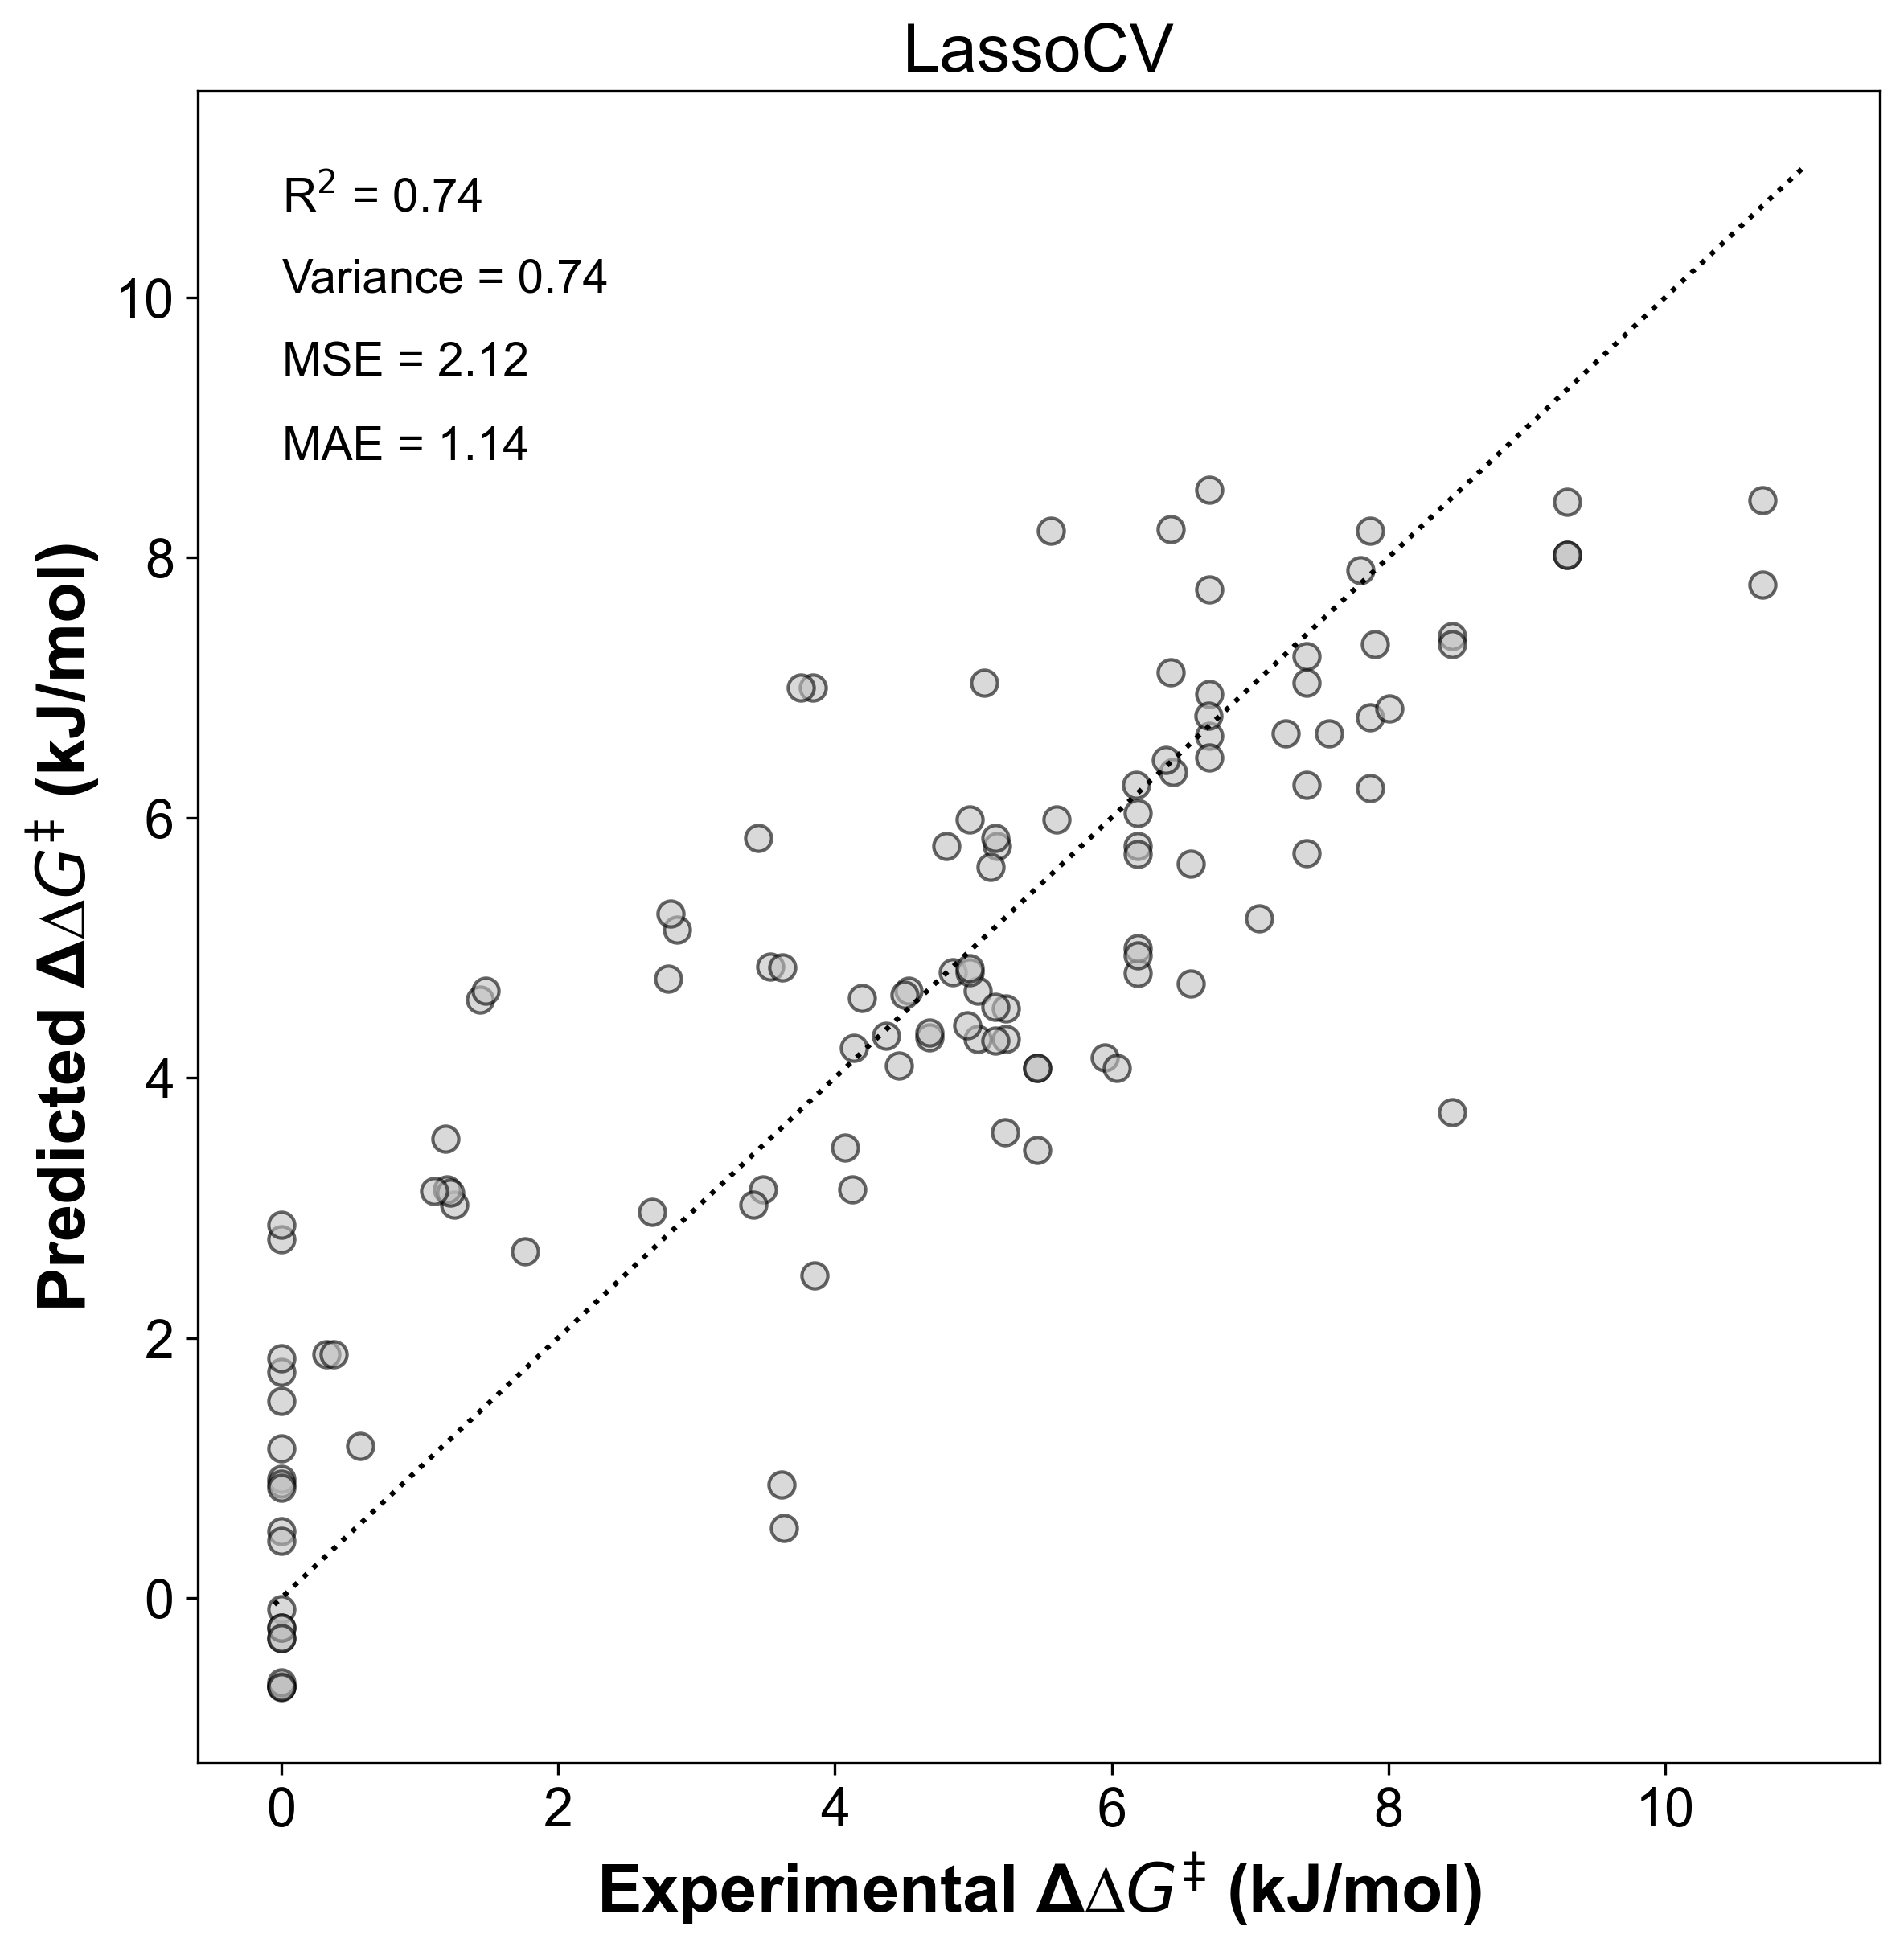

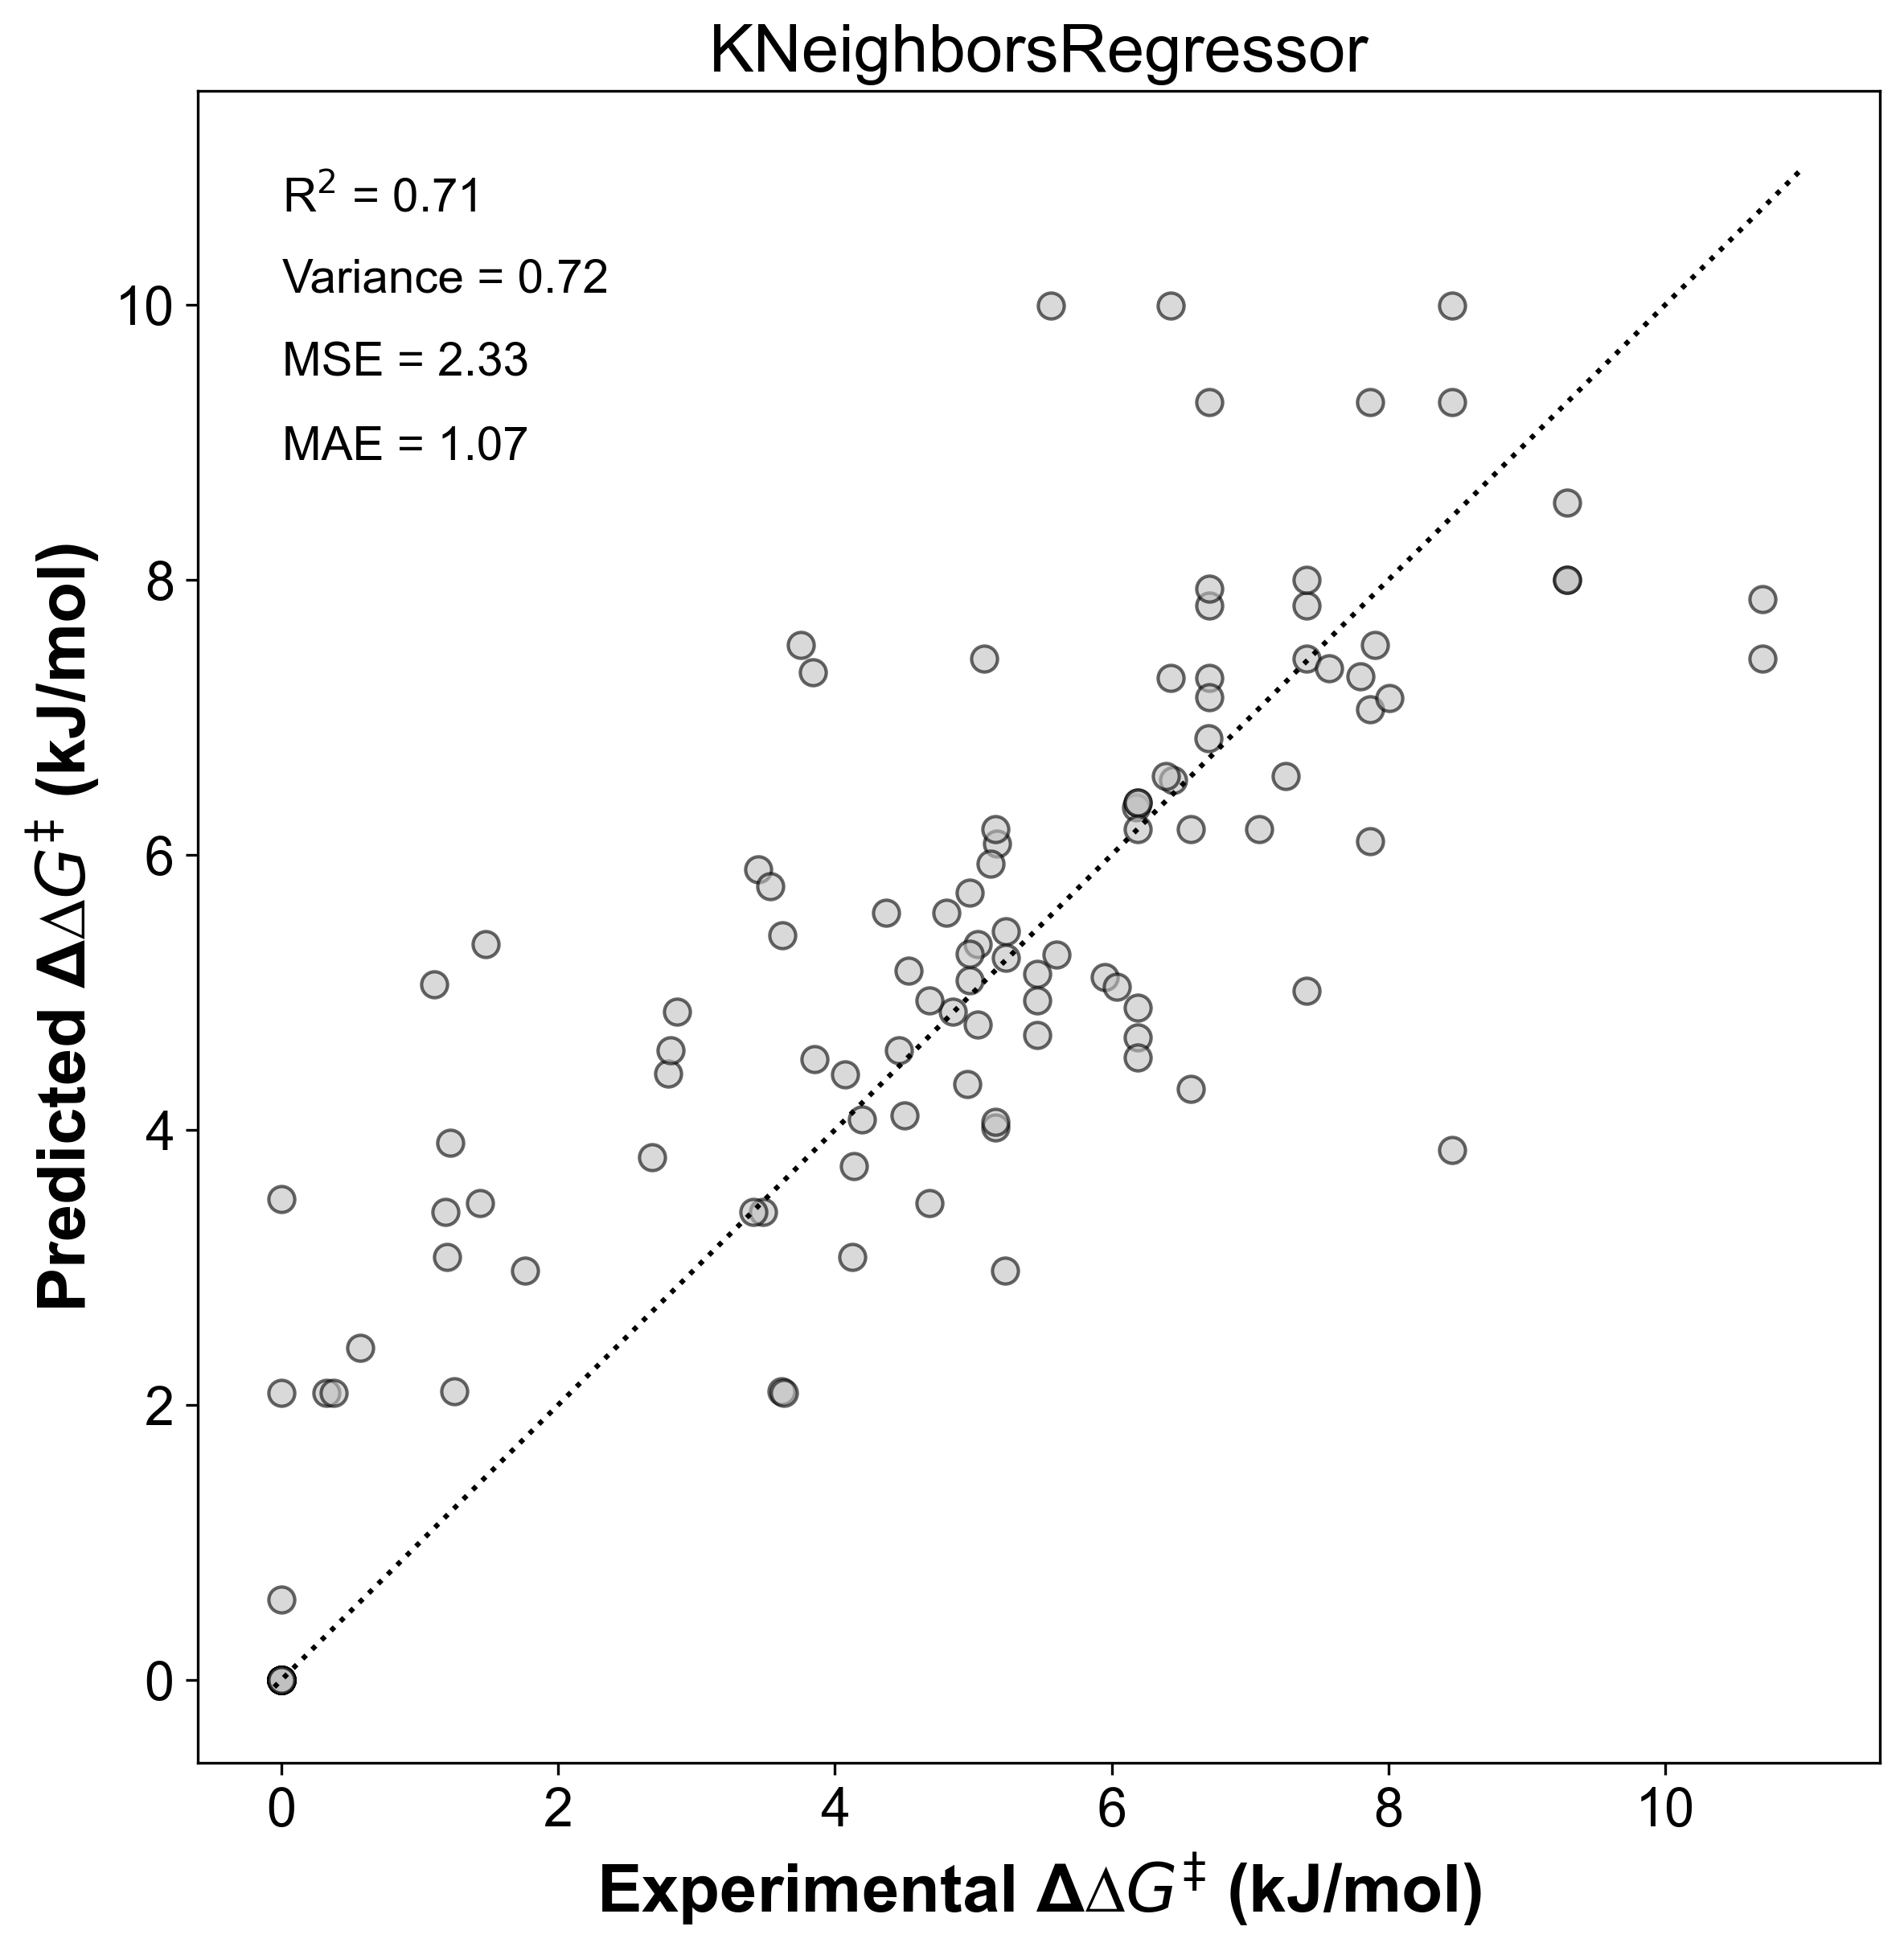

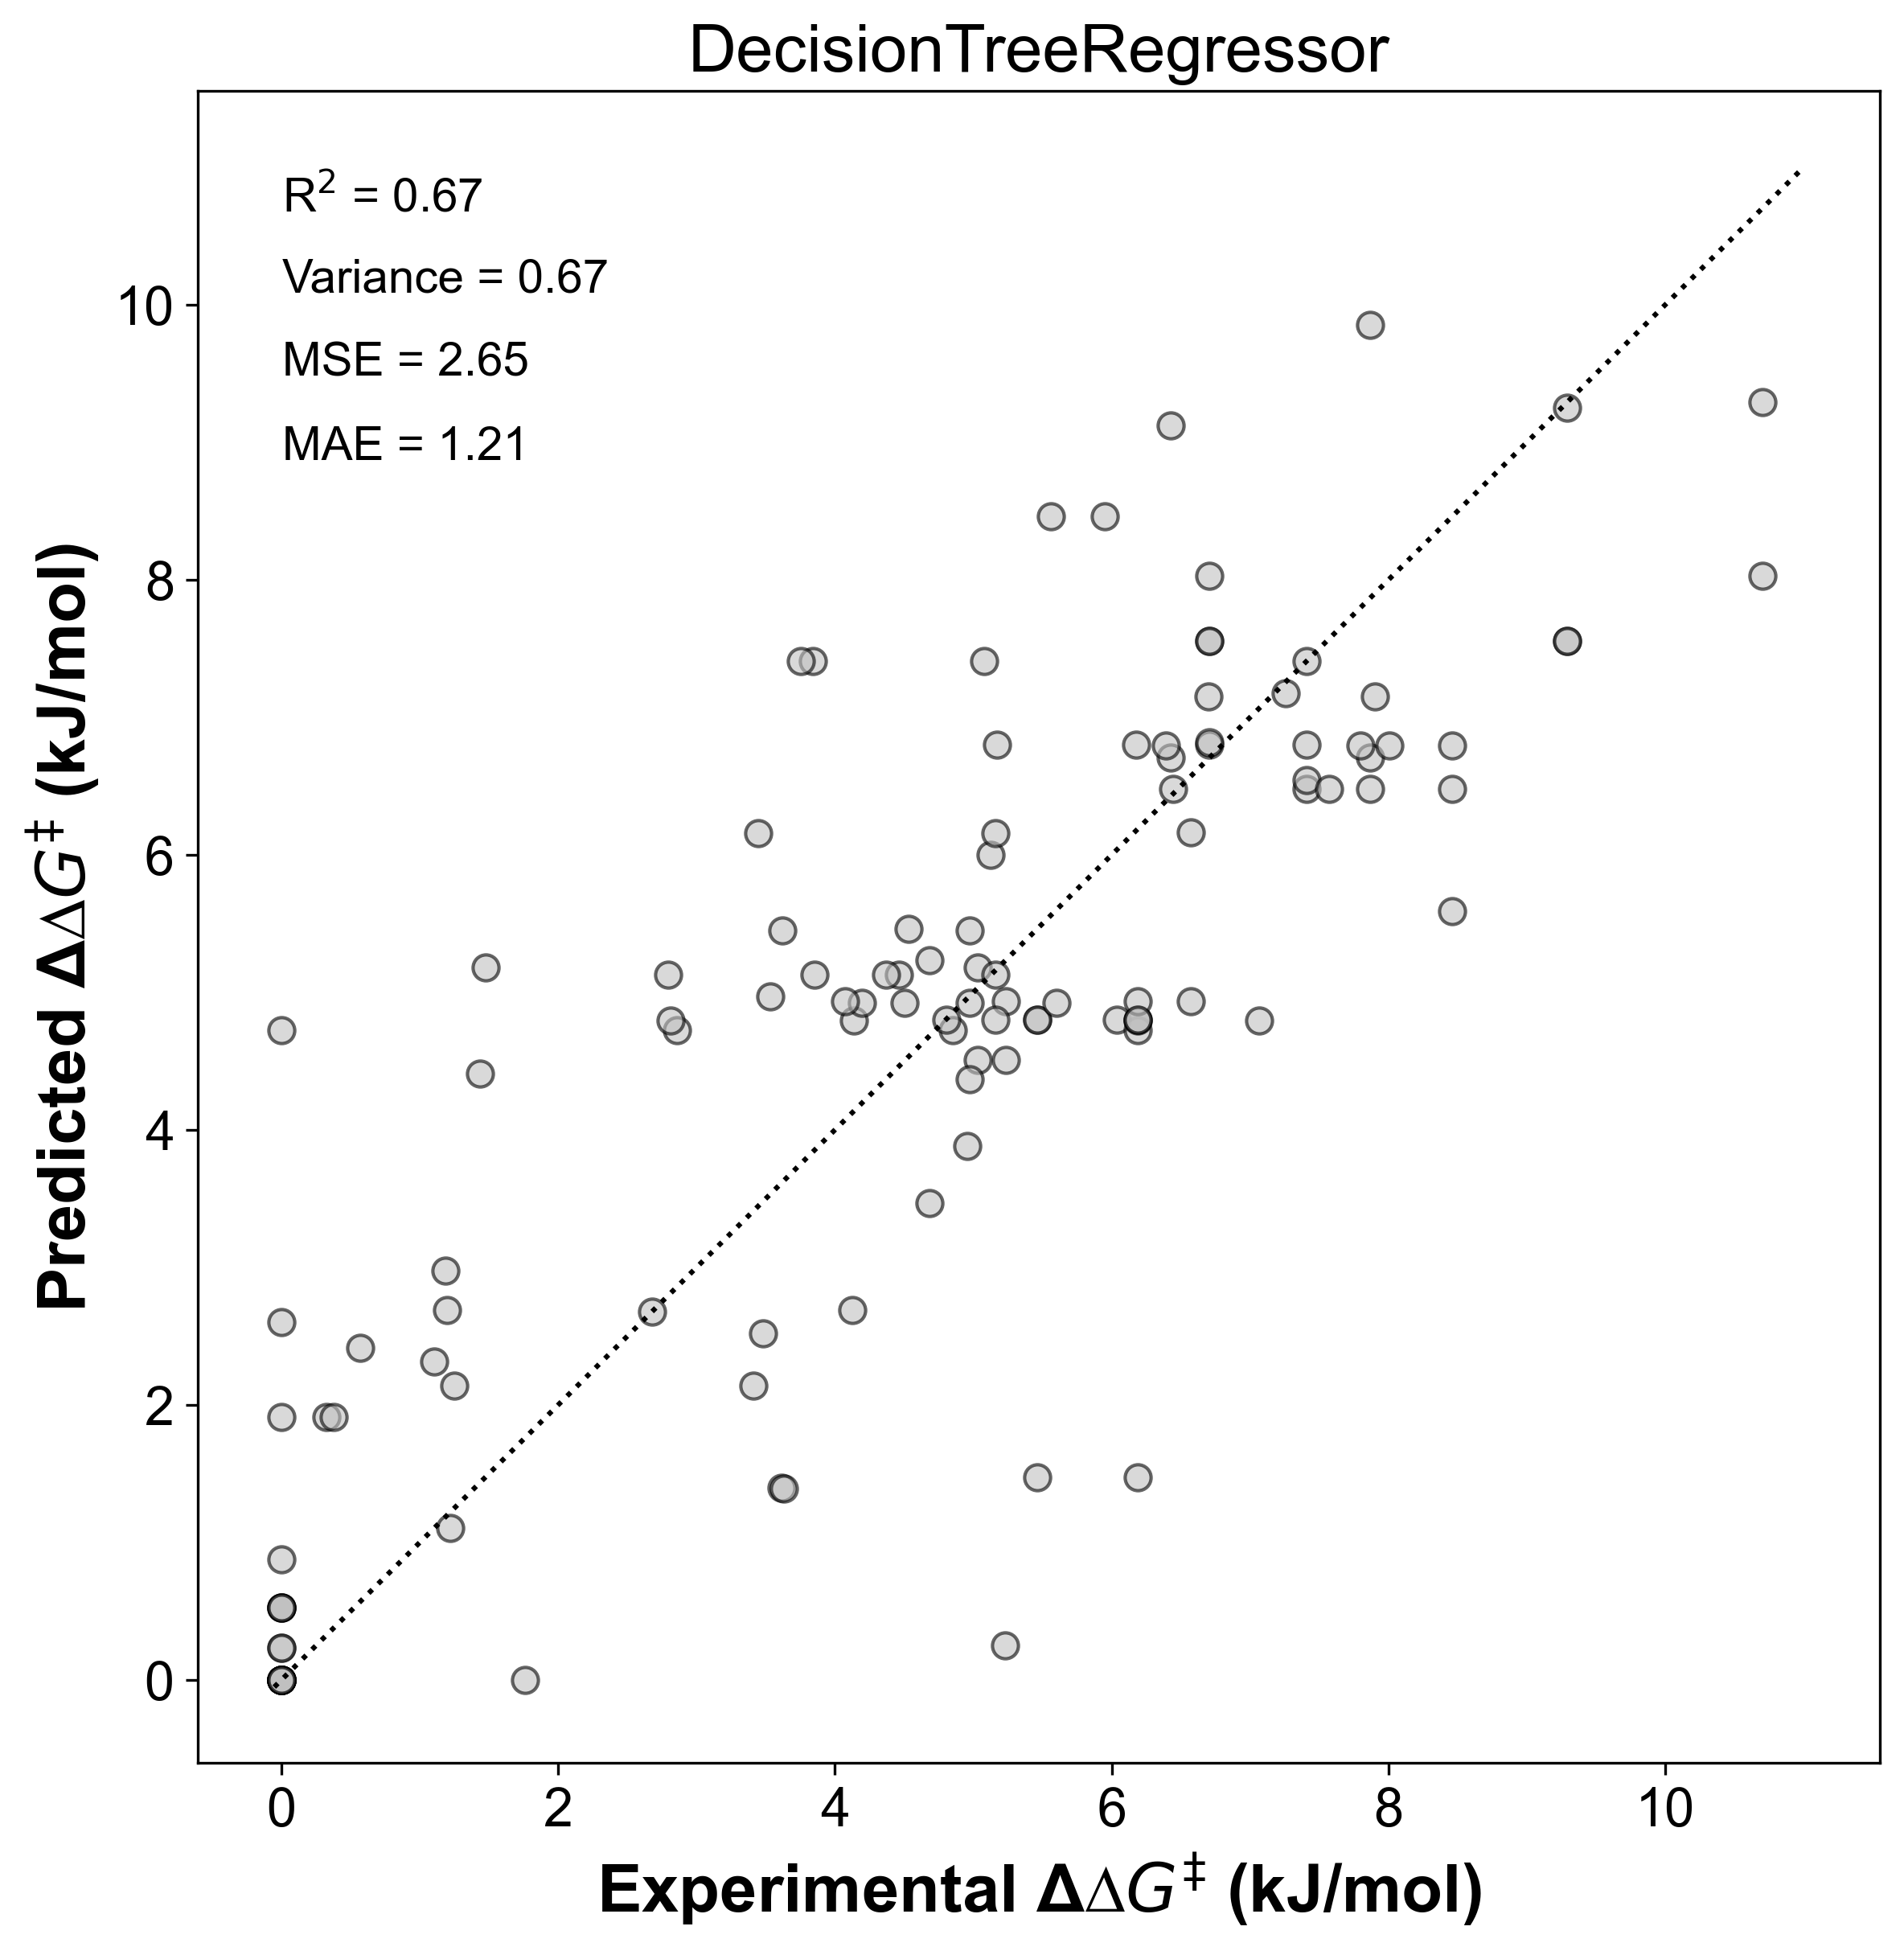

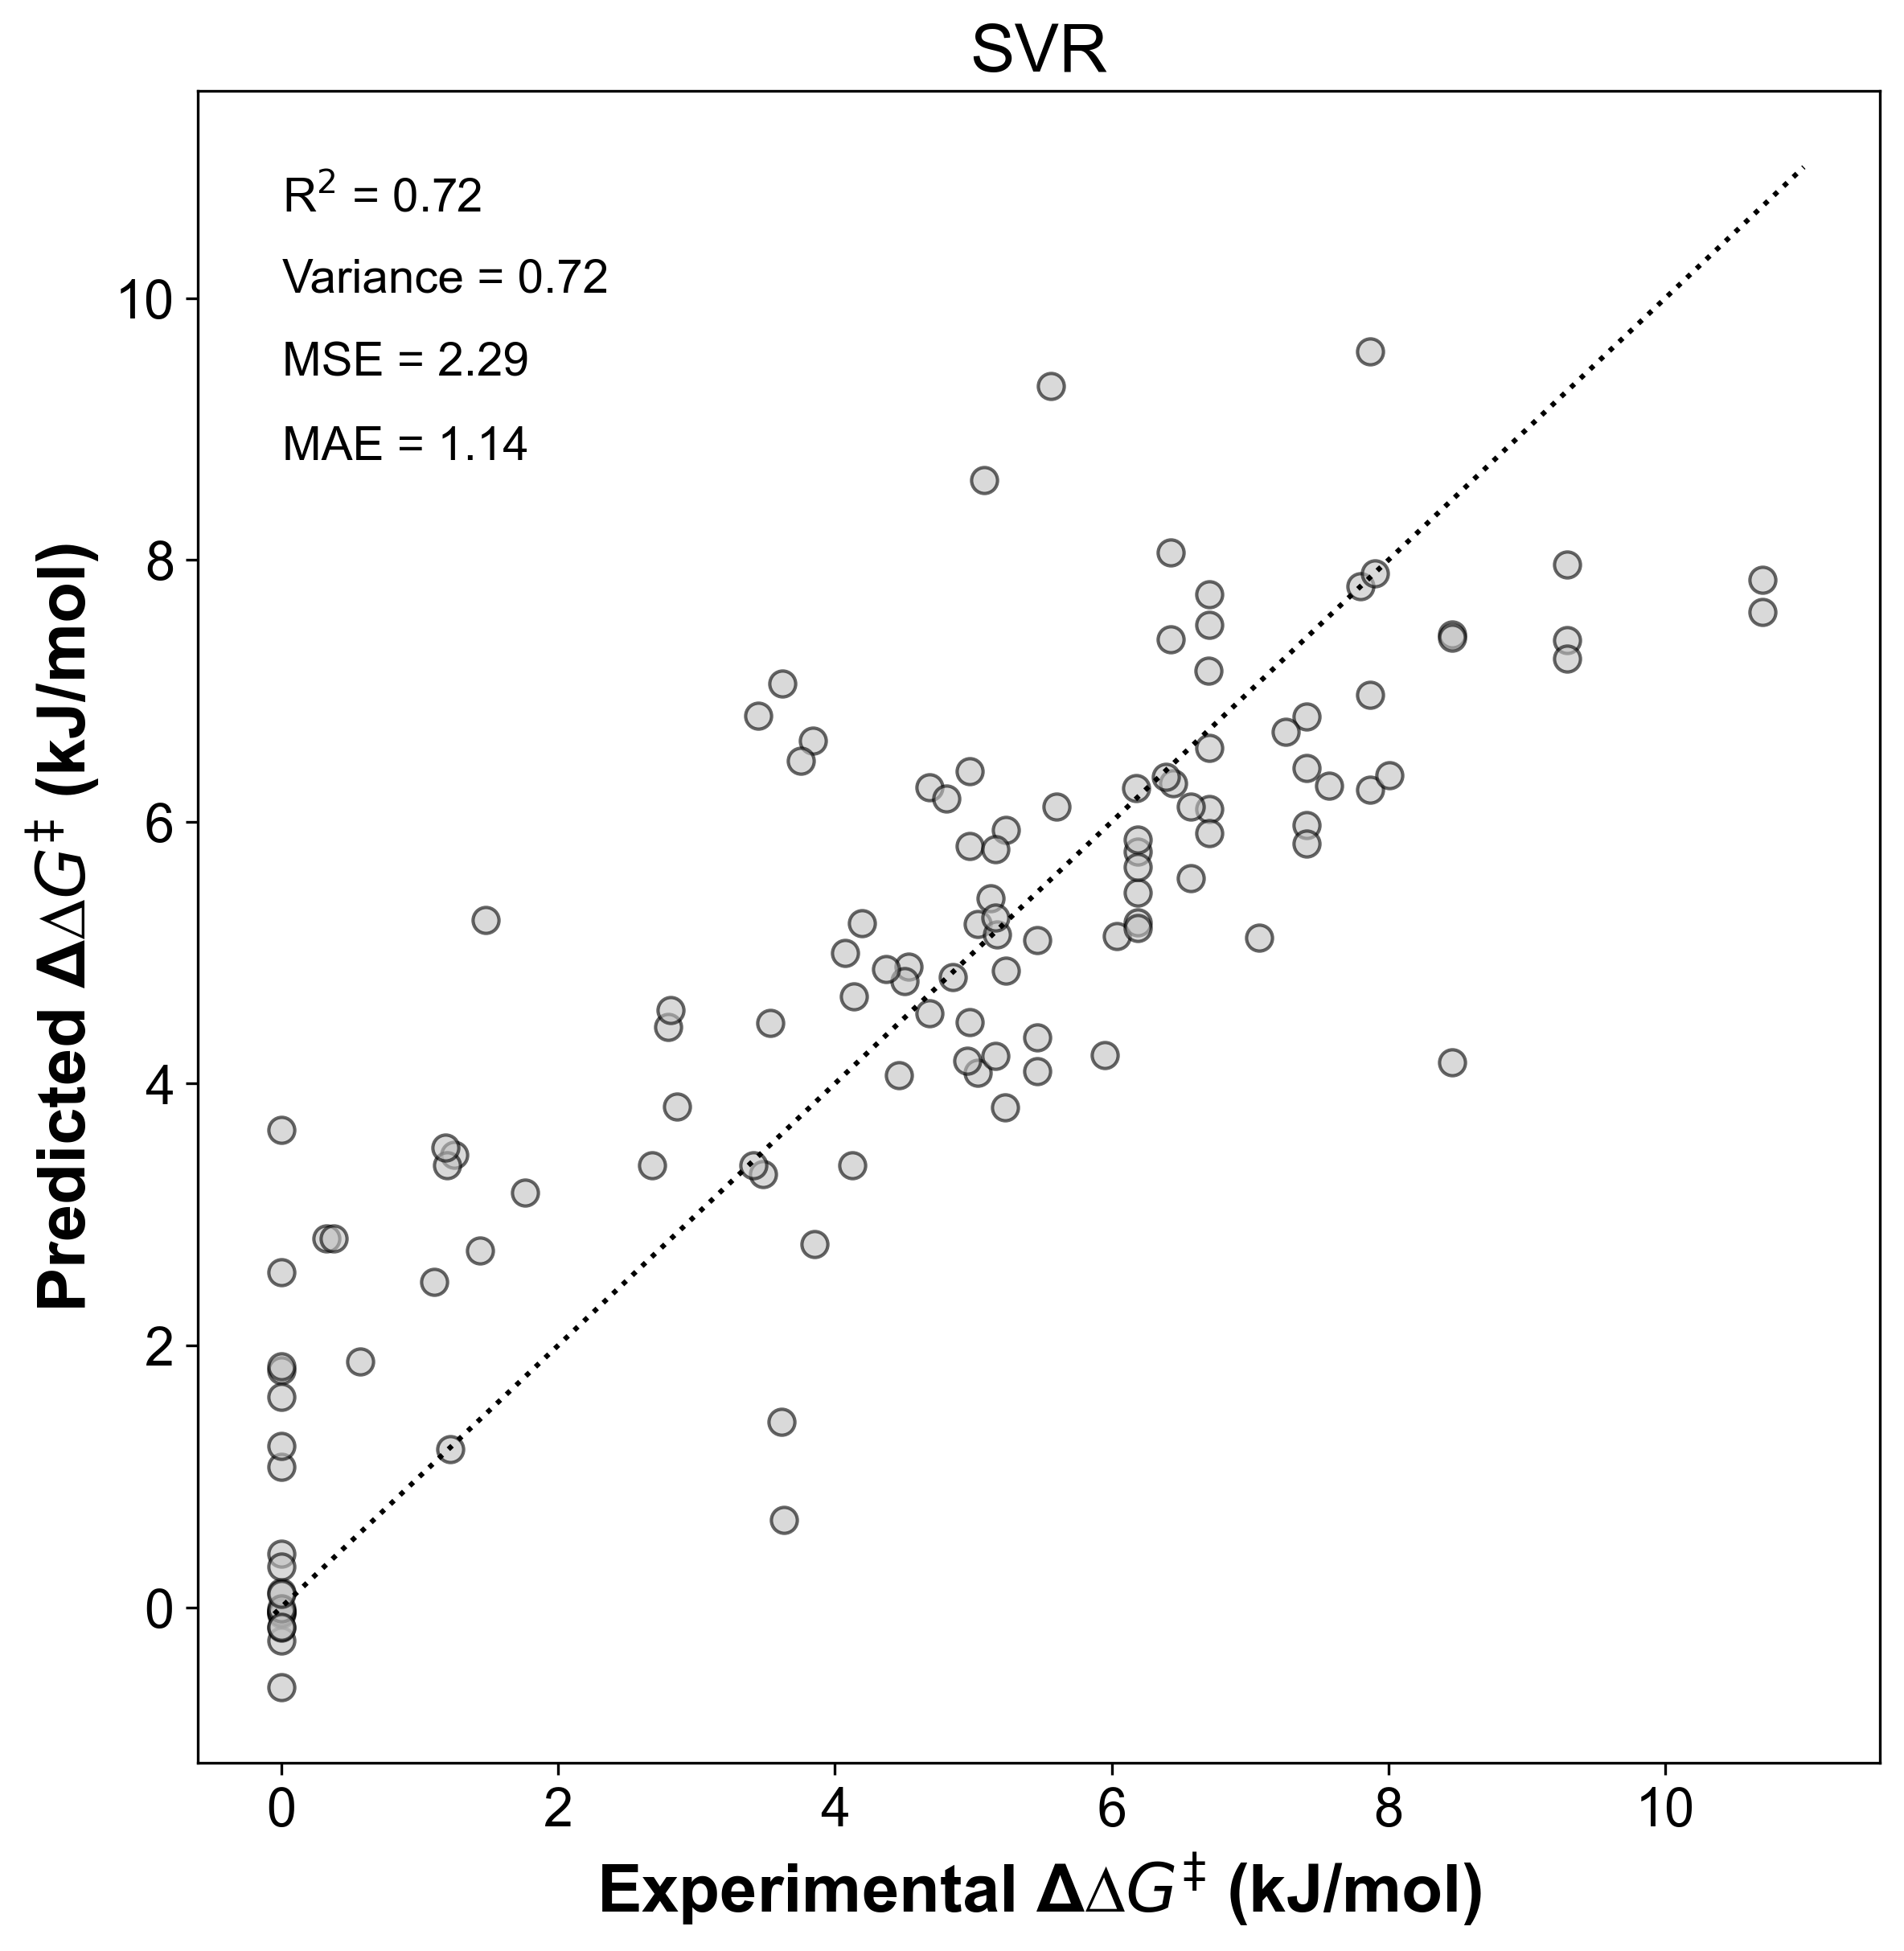

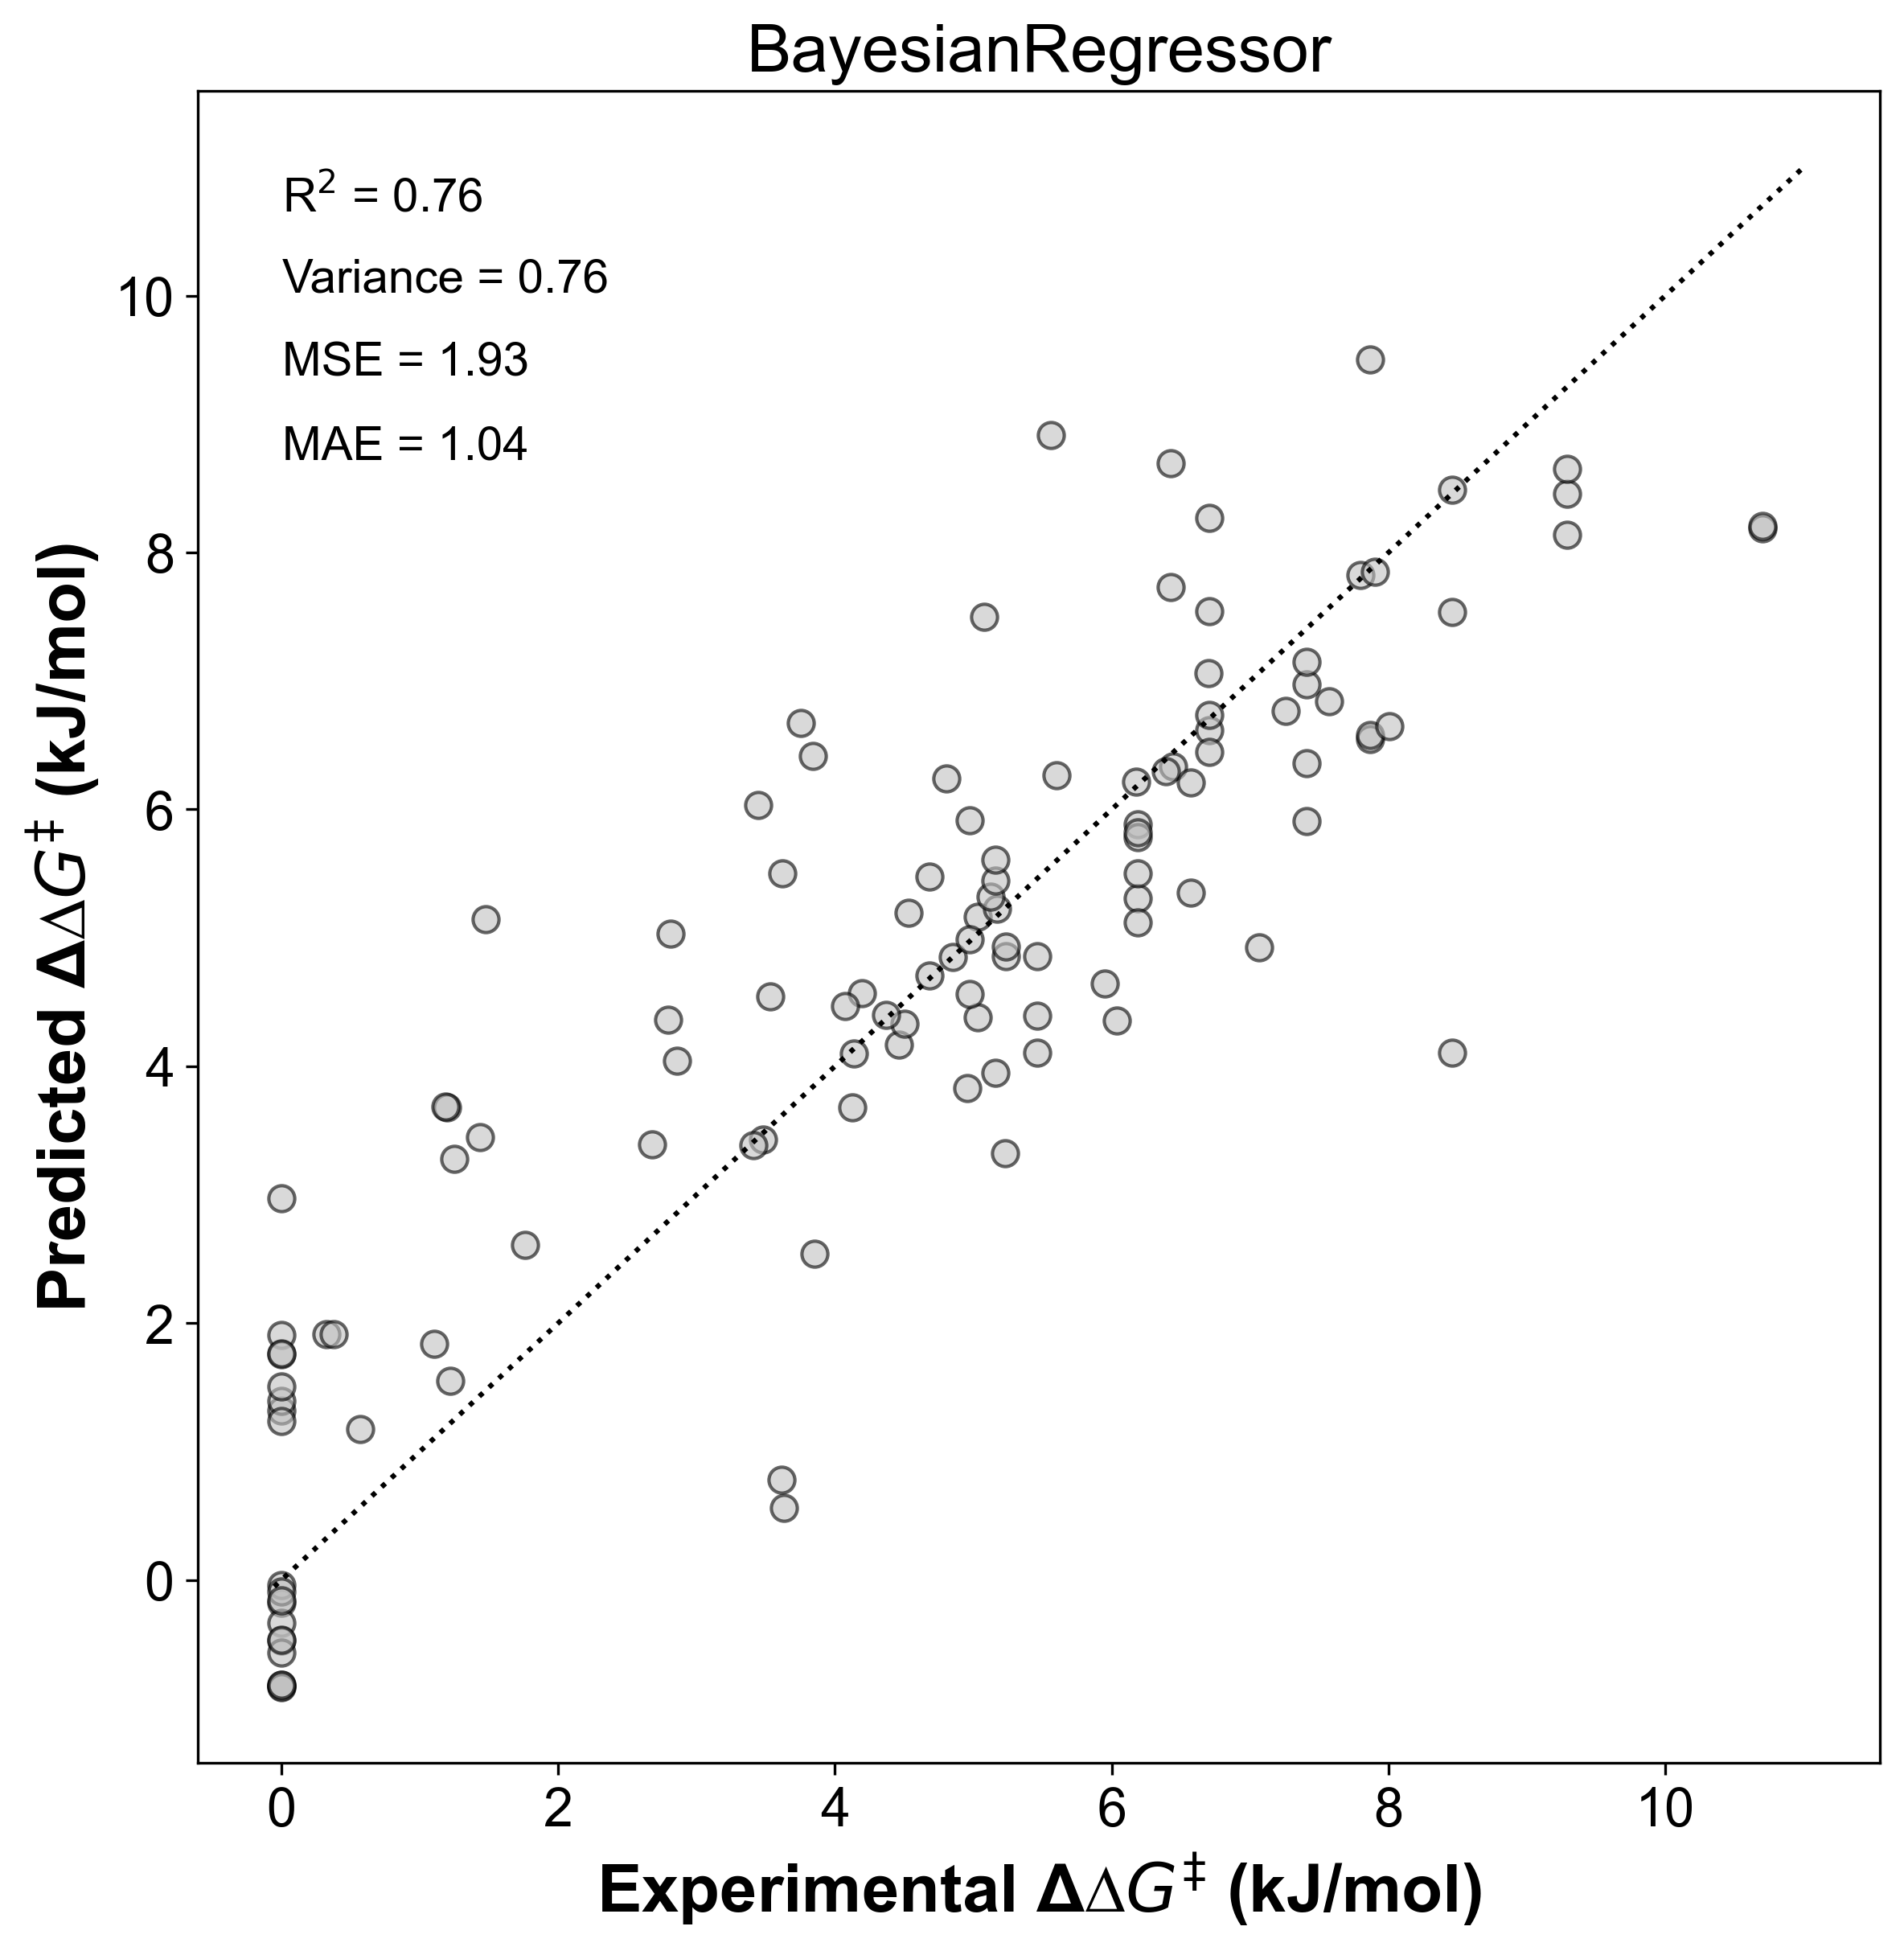

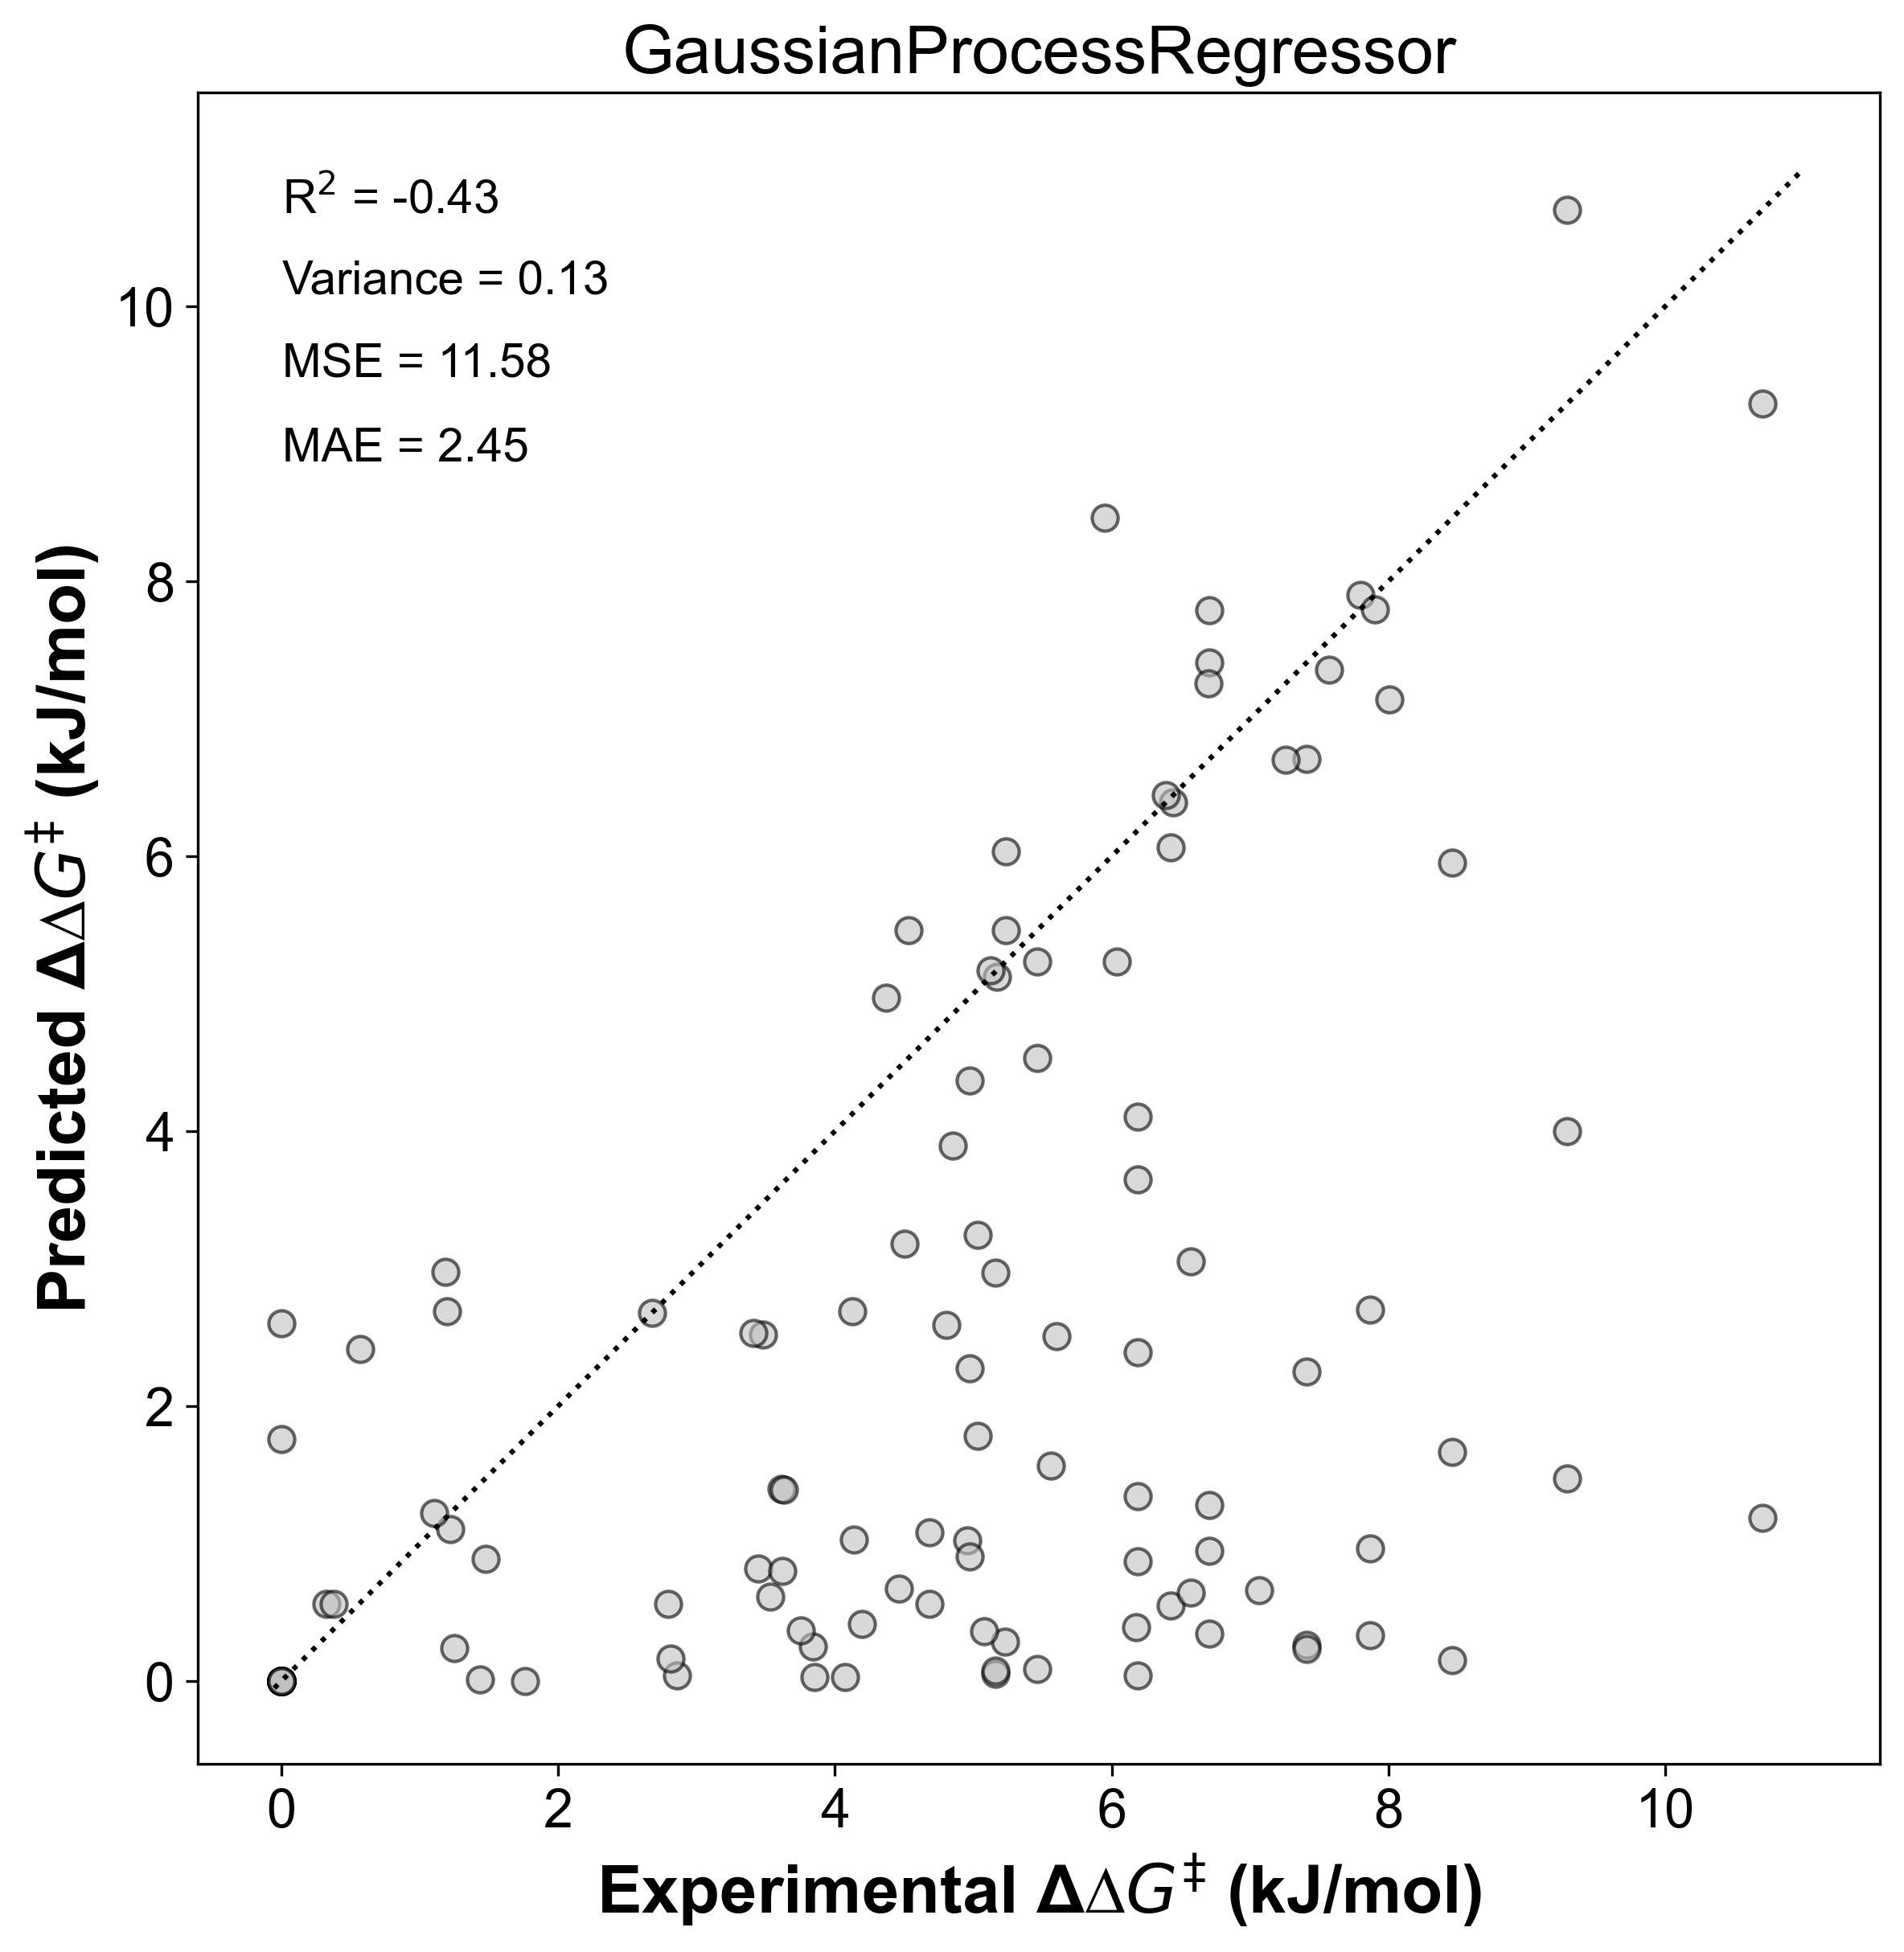

In [20]:
wf.metrics_for_regression(directories=directory_names)

# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. If you are not familiar with the process please read the paper section where this is explained.


In [21]:
data = pd.read_csv("../First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

We have used a standard test set, but if you want a random one you can just use the train_test_split function from sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [22]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57,52]

In [23]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


In [24]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [25]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [26]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

temp_train = train_data["temperature"]
log.info("DGG: {}".format(temp_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [27]:
target_train = ddg_train

In [28]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

temp_test = test_data["temperature"]
log.info("DGG: {}".format(temp_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 21     COC(C=CC=C1)=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
81                          C=CC/N=C/C1=C(OC)C=CC=C1
11         CC1(CCCCC1)/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
104      C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
44               C/C(C1=CC=CC=C1)=N\CC2=CC=C(OC)C=C2
Name: substrate, dtype: object
Catalyst SMILES: 21     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
81     O=C([C@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=C...
11     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
104    S=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)N[C@H]2[C...
44     O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...
Name: catalyst, dtype: object
DGG: 21    -30.0
81    -70.0
11    -30.0
104   -30.0
44    -75.0
Name: temperature, dtype: float64
DGG: 21     5.562698
81     3.446852
11     7.406515
104    0.000000
44     5.464455
Name: ddg, dtype: float64


In [29]:
target_test = ddg_test

Generating Fingerprints for the training set

First for the substrates

In [30]:
features1_train,features_df1_train = fp.morgan_fingerprints(substratesmiles_train)

In [31]:
feats1 = features_df1_train.loc[:, (features_df1_train != 0).any(axis=0)]

Then for catalysts

In [32]:
features2_train,features_df2_train = fp.morgan_fingerprints(catalystsmiles_train)

In [33]:
feats2 = features_df2_train.loc[:, (features_df2_train != 0).any(axis=0)]

merge the two

In [34]:
features_df_train = feats1.join(feats2, lsuffix="features1", rsuffix="features2")

In [35]:
features_df_train = features_df_train.join(temp_train.reset_index(drop=True))

In [36]:
features_df_train.columns = features_df_train.columns.astype(str)

In [37]:
features_df_train

,0features1,2features1,4features1,6,8features1,16,28,33,43,57,...,955,964,966features2,971,979,988,993features2,1016features2,1017,temperature
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
1,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
2,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
3,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
4,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,-75.0
103,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,-75.0
104,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
105,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,-75.0


# Handling the Test Set


In [38]:
features1_test,features_df1_test = fp.morgan_fingerprints(substratesmiles_test)

In [39]:
a = features_df1_test.columns.intersection(feats1.columns)

In [40]:
feat1_test = features_df1_test.drop(columns=[col for col in features_df1_test if col not in a])

In [41]:
features2_test,features_df2_test = fp.morgan_fingerprints(catalystsmiles_test)

In [42]:
b = features_df2_test.columns.intersection(feats2.columns)

In [43]:
feat2_test = features_df2_test.drop(columns=[col for col in features_df2_test if col not in b])

In [44]:
features_df_test = feat1_test.join(feat2_test, lsuffix="features1", rsuffix="features2")

In [45]:
features_df_test = features_df_test.join(temp_test.reset_index(drop=True))

In [46]:
features_df_test.columns = features_df_test.columns.astype(str)

In [47]:
features_df_test

,0features1,2features1,4features1,6,8features1,16,28,33,43,57,...,955,964,966features2,971,979,988,993features2,1016features2,1017,temperature
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
1,1,1,1,0,0,0,0,0,0,1,...,1,1,1,0,0,0,1,1,0,-70.0
2,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
3,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,1,-30.0
4,1,1,1,0,0,0,0,1,0,0,...,1,1,1,0,0,0,1,1,0,-75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1,1,1,0,0,0,0,1,0,0,...,1,1,1,0,0,0,1,1,0,-70.0
8,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
9,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0
10,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,-30.0


In the lines above we have generated the fingerprints again. you don't have to do this, you could just split the features_df drataframe according to your needs.

# Define Xtrain, Xtest, Ytrain, Ytest


In [48]:
Xtrain = features_df_train
Xtest = features_df_test
Ytrain = target_train
Ytest = target_test

You can skip regressors that did not perform well in the previous step. or not, up to you

In [49]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR",
                   "BayesianRegr", "GaussianProcessRegressor", "RandomForestRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor(),
    RandomForestRegressor(random_state=random_seed)]# takes some time, you can remove some options for the parameters

kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
    "RandomForestRegressor":{'n_estimators': [10,20],'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['auto','sqrt','log2'],'bootstrap': [True, False],'warm_start': [True, False]}
}

# Time for ML


In [50]:
%%capture
wf.split_test_regressors_with_optimization(Xtrain,Ytrain,Xtest,Ytest, kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
	name: LassoCV parameters: {}

	 The predictions are: [ 8.08517772  5.7781971   6.2726698   3.14892577  4.31063779  1.95814794
  5.64327133  5.03098758 -0.40506751  8.08517772  3.16824881  6.6433782 ]
{'name': 'LassoCV', 'variance': 0.82, 'MAE': 0.93, 'MSE': 1.45, 'RMSE': 1.2041594578792296, 'R2': 0.82}
{'name': 'LassoCV', 'variance': 0.74, 'MAE': 1.49, 'MSE': 2.96, 'RMSE': 1.7204650534085253, 'R2': 0.67}

-----
Begin KNeighborsRegressor
-----

Directory KNeighborsRegressor already exists will be overwritten
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	 The predictions are: [9.76031908 5.99283929 7.52567376 0.         4.80582323 0.
 6.10009555 5.41242555 1.20407129 8.42835835 3.42778321 7.52567376]
{'name': 'KNeighborsRegressor', 'variance': 0.88, 'MAE': 0.69, 'MSE': 1.04, 'RMSE': 1.019803902718557, 'R2': 0.87}
{'name': 'KNeighborsRegressor', 'varia

# Ensamble learning

To improve the predictive performance, ensemble ML methods have been developed that combine multiple ML models. 
Stacking, is one ensamble learning approach where a meta-estimator is trained on the predictions of previous ML models (RF, a kNN, and a SVMs). For example, the LR model can be trained on the predictions of a DT, a kNN, and a SVM.

Here you should inprinciple use models that perform well. As an example we use the two regressors that gave the best results for us. Change the names to the regressors that worked best for you

In [51]:
kfold_reg_names = ["BayesianRegr", "SVR"]
directory_names = wf.directory_names(kfold_reg_names)


	 Reading:BayesianRegr/predictions.csv 

	 Reading:SVR/predictions.csv 

	 Gathered all predictions 

	Calculating metrics
{'mae': 1.2374539818928199, 'mse': 2.3688577509856743, 'rmse': 1.5391094018898313, 'r2': 0.7327922184249867}


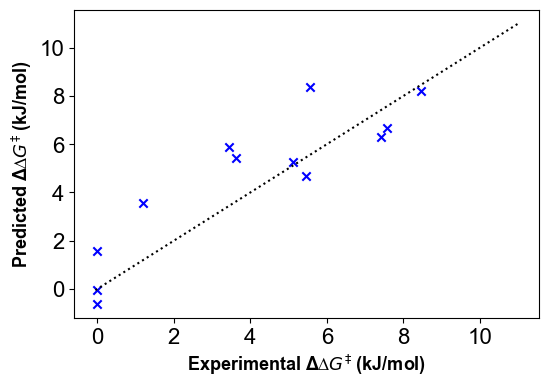

In [52]:
csv_files=[]
for directory in directory_names:
    csv_files.append(os.path.join(directory, 'predictions.csv'))
ensemble_metrics = wf.ensemble(csv_files)
log.info(ensemble_metrics)